# 实验课1：基于模板的手写数字识别

In [11]:
import pandas as pd
import numpy as np
import os
import cv2
import re
from matplotlib import pyplot as plt

### 标准模板库制作

+ 灰度化

In [2]:
def graying(img):
    img =cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh=cv2.threshold(img,100,255,cv2.THRESH_BINARY)
    img = thresh
    return thresh

In [18]:
def graying2(img):
    img =cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh=cv2.threshold(img,100,255,cv2.THRESH_BINARY)
    cv2.bitwise_not(thresh,thresh);
    img = thresh
    return thresh

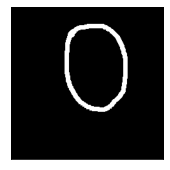

In [24]:
imgs = cv2.imread("./data/test-images2/0-1.bmp")
imshow(graying2(imgs))

+ 基于matplotlib和jupyter的特殊opencv图像显示方式

In [3]:
def imshow(img):
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow(img2)

+ 裁剪图片
  1. 利用findContours找到边缘
  2. 利用找到的边缘进行筛选和切割

In [4]:
def splitImg(img):
    #img = graying(img)
    contours,hierarchy = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for i in range(len(contours)):
        x,y,w,h = cv2.boundingRect(contours[i])
        #print([x,y,w,h])
    img = img[y:y+h,x:x+w]
    return img

In [5]:
def cutImg(img):
    row, col = img.shape[0],img.shape[1]
    a,b,c,d=0,0,0,0
    f = 1
    for i in range(col):
        for j in range(row):
            if img[i,j]>150:
                if f == 1:
                    a = i
                    f = 0
                else:
                    b = i
    f = 1
    for j in range(row):
        for i in range(col):
            if img[i,j] > 150:
                if f == 1:
                    c = j
                    f = 0
                else:
                    d = j
    #print(a,b,c,d)
    img = img[a:b+1,c:d+1]
    return img

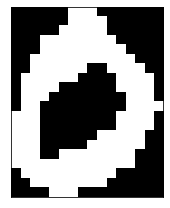

In [6]:
img_temp = cv2.imread("./data/train-images/0_0.bmp")
img_temp = graying(img_temp)
imshow(cutImg(img_temp))

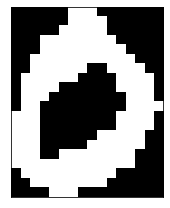

In [7]:
imshow(splitImg(img_temp))

+ 依据5x5标准进行标准化，得到标准化后的矩阵值
  + 计算每个单元格w与h时，采用对小数点后的位数四舍五入，并特殊处理最后一个单元格

In [8]:
def standard(img):
    w,h = img.shape[1],img.shape[0]
    w_i,h_i=[],[]
    n_grids = 10
    for i in range(n_grids):w_i.append(w//n_grids)
    for i in range(n_grids):h_i.append(w//n_grids)
    # 归一化
    loss = 0.5
    w_end,h_end = 0,0
    arr_matrix = []
    percent = []
    for i in range(n_grids):
        col = w_end
        w_end += w_i[i]
        h_end = 0
        for j in range(n_grids):
            count = 0
            count_a = 0
            row = h_end
            col = w_end-w_i[i]
            h_end += h_i[j]
            while col<w_end:
                row = h_end-h_i[j]
                while row<h_end:
                    if img[row,col] > 150:
                        count +=1
                    count_a +=1
                    row +=1
                col +=1
            percent.append(count/count_a)
            if count/count_a > loss:
                arr_matrix.append(1)
            else:
                arr_matrix.append(0)
    matrix = np.array(arr_matrix).reshape(n_grids,n_grids).T
    return matrix,percent

+ 构造所有训练图像的标准库

In [9]:
#图片地址
def getTrain():
    local = './data/train-images/'
    if_train = 1
    if os.path.exists(r"./data/output.csv"):
        input_f_csv = pd.read_csv("./data/output.csv",index_col=0)
        #print(input_f_csv.shape)
        #print(input_f_csv)
        if input_f_csv.shape[0] == 10 and input_f_csv.shape[1] == 100:
            if_train = 0
            std_library = input_f_csv
        else:
            os.remove(r"./data/output.csv")
    if if_train:
        std_library = pd.DataFrame(columns=range(100))#1-->100
        std_library_pcr = pd.DataFrame(columns=range(100))#1-->100
        for n in range(10):#1-->10
            arr_ =[]
            arr2_=[]
            for m in range(100):#1-->100
                img = cv2.imread("%s%s_%s.bmp"%(local,n,m))
                img = graying(img)
                #img = splitImg(img)
                img = cutImg(img)
                img = cv2.resize(img,(100,100))
                ret,img = cv2.threshold(img,100,255,cv2.THRESH_BINARY)
                cv2.imwrite("./data/std-images/%s_%s.bmp"%(n,m),img)
                std_matrix,pcr = standard(img)
                str_std= ''
                str_pcr = ",".join(map(str,pcr))
                for i in std_matrix.tolist():str_std = "%s,%s"%(str_std,",".join(map(str,i)))
                arr_.append(str_std[1:])
                arr2_.append(str_pcr[1:])
                # print(std_matrix)
            std_library.loc[n] = arr_
            std_library_pcr.loc[n] = arr2_
        #print(std_library)
        std_library.to_csv("./data/output.csv")
        std_library_pcr.to_csv("./data/output_pcr.csv")
        #imshow(img)
        print("Start from creating.")
    else:
        print("Start from CSV file.")
    
    return std_library


# 转字符串为numpy矩阵
# np.array(list(map(int,str_std[1:].split(',')))).reshape(10,10)


### 读入测试集并与标准库比对

In [27]:
%%time
local_test = './data/test-images2/'
dic_output = {}
output_ = {}
std_library = getTrain()
all_nums = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
for root, dirs, files in os.walk(local_test):
    for file in files:
        nums = re.findall("\d",file)
        n,m = nums[0],nums[1]
        n,m = int(n),int(m)
        img = cv2.imread("%s%s"%(local_test,file))
        img = graying2(img)
        #img = splitImg(img)
        img = cutImg(img)
        img = cv2.resize(img,(100,100))
        ret,img = cv2.threshold(img,100,255,cv2.THRESH_BINARY)
        test_matrix,test_percent = standard(img)
        #print(test_matrix)
        hit,index,cols = 100,0,0
        for row in std_library.itertuples():
            for i in range(1,101):#2-->101
                now_str = getattr(row,"_%s"%i)
                now_matrix = np.array(list(map(int,now_str.split(',')))).reshape(10,10)
                #print(now_matrix)
                sub = np.sqrt(np.sum(np.square(now_matrix-test_matrix)))
                if sub < hit: 
                    hit = sub
                    index = row.Index
                    cols = i
        #alll += 1
        all_nums[n][0] += 1
        if hit <= 15 :
        # 识别正确
            #sc +=1
            all_nums[n][1] += 1
            str_name = "%s_%s"%(n,m)
            dic_output[str_name] = "%s_%s"%(index,i)
        elif hit <30 and 15<hit:
        # 识别错误
            #no +=1
            all_nums[n][2] += 1
            str_name = "%s_%s"%(n,m)
            dic_output[str_name] = "fail"
        elif hit >=30:
        # 拒绝识别
            #re +=1
            all_nums[n][3] += 1
            str_name = "%s_%s"%(n,m)
            dic_output[str_name] = "refuse"
        #print(file)
        #break
        
print(all_nums)


Start from CSV file.
[[10, 10, 0, 0], [10, 10, 0, 0], [10, 10, 0, 0], [10, 10, 0, 0], [10, 10, 0, 0], [10, 10, 0, 0], [10, 10, 0, 0], [10, 10, 0, 0], [10, 10, 0, 0], [10, 10, 0, 0]]
CPU times: user 17.6 s, sys: 11.9 ms, total: 17.6 s
Wall time: 17.6 s


'\nfor n in range(10):#1-->10\n    sc,no,re,alll = 0,0,0,0\n    for m in range(20):#1-->20\n        img = cv2.imread("%s%s_%s.bmp"%(local_test,n,m))\n        img = graying(img)\n        img = splitImg(img)\n        img = cv2.resize(img,(100,100))\n        ret,img = cv2.threshold(img,100,255,cv2.THRESH_BINARY)\n        test_matrix,test_percent = standard(img)\n        #print(test_matrix)\n        hit,index,cols = 100,0,0\n        for row in std_library.itertuples():\n            for i in range(1,101):#2-->101\n                now_str = getattr(row,"_%s"%i)\n                now_matrix = np.array(list(map(int,now_str.split(\',\')))).reshape(10,10)\n                #print(now_matrix)\n                sub = np.sqrt(np.sum(np.square(now_matrix-test_matrix)))\n                if sub < hit: \n                    hit = sub\n                    index = row.Index\n                    cols = i\n        alll += 1\n        if hit <= 15 :\n        # 识别正确\n            sc +=1\n            str_name = "%

In [ ]:
for n in range(10):#1-->10
    sc,no,re,alll = 0,0,0,0
    for m in range(20):#1-->20
        img = cv2.imread("%s%s_%s.bmp"%(local_test,n,m))
        img = graying(img)
        img = splitImg(img)
        img = cv2.resize(img,(100,100))
        ret,img = cv2.threshold(img,100,255,cv2.THRESH_BINARY)
        test_matrix,test_percent = standard(img)
        #print(test_matrix)
        hit,index,cols = 100,0,0
        for row in std_library.itertuples():
            for i in range(1,101):#2-->101
                now_str = getattr(row,"_%s"%i)
                now_matrix = np.array(list(map(int,now_str.split(',')))).reshape(10,10)
                #print(now_matrix)
                sub = np.sqrt(np.sum(np.square(now_matrix-test_matrix)))
                if sub < hit: 
                    hit = sub
                    index = row.Index
                    cols = i
        alll += 1
        if hit <= 15 :
        # 识别正确
            sc +=1
            str_name = "%s_%s"%(n,m)
            dic_output[str_name] = "%s_%s"%(index,i)
        elif hit <30 and 15<hit:
        # 识别错误
            no +=1
            str_name = "%s_%s"%(n,m)
            dic_output[str_name] = "fail"
        elif hit >=30:
        # 拒绝识别
            re +=1
            str_name = "%s_%s"%(n,m)
            dic_output[str_name] = "refuse"
    
    output_["%s"%n] = "%s%%,%s%%,%s%%"%(sc/alll*100,no/alll*100,re/alll*100)
    
print(output_)